In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)
import torch

In [3]:
from ImportanceSampling.SamplingAlgorithms.NUTS import NUTS
from ImportanceSampling.SamplingAlgorithms.HamiltonianMonteCarlo import HMC
from ImportanceSampling.SamplingAlgorithms.Metropolis import Metropolis

In [4]:
# import target and sampling model
from TargetDistributions.MoG import custom_MoG
from FittedModels.Models.FlowModel import FlowModel
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.train import LearntDistributionManager
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function

# import plotting stuff
from Utils.plotting_utils import plot_distribution
from FittedModels.utils.plotting_utils import plot_distributions, plot_samples
from Utils.DebuggingUtils import timer


# Target Problem

In [5]:
dim = 2
target = custom_MoG(locs_=(-6, -1, 1, 2, 5), dim=dim, cov_scaling=0.01)

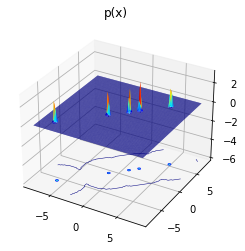

In [6]:
width = 8
plot_distribution(target, bounds=[[-width, width], [-width, width]])

In [7]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=10,
                           scaling_factor=4.0)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling)

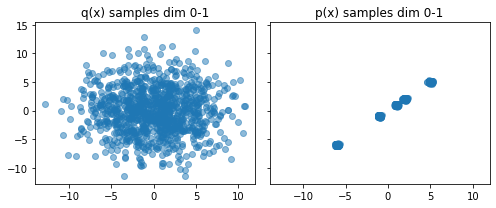

In [8]:
plot_samples(tester)

In [9]:
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # should print 2 similar-ish number

tensor(81.8874)
tensor(81.9177)


# NUTS

In [21]:
M = 4
NUTTER = NUTS(2, target.log_prob)
# 100 samples
theta_init = learnt_sampler.sample((100,))
nuts_time = timer("nuts")
samples_NUTS = NUTTER.run(theta_init, M=M)
nuts_time.stop()
# adaption occuring

# adaption complete
nuts_time = timer("nuts")
samples_NUTS = NUTTER.run(theta_init, M=M)
nuts_time.stop()

estimated_expectation = torch.mean(expectation_function(samples_NUTS))
print(estimated_expectation)


Duration of 0.08172369003295898 for nuts


Duration of 0.015649795532226562 for nuts

tensor(48.3518, grad_fn=<MeanBackward0>)


In [22]:
NUTTER = NUTS(2, target.log_prob)
# 1000 samples
theta_init = learnt_sampler.sample((1000,))
nuts_time = timer("nuts")
samples_NUTS = NUTTER.run(theta_init, M=M)
nuts_time.stop()
# adaption occuring

# adaption complete
nuts_time = timer("nuts")
samples_NUTS = NUTTER.run(theta_init, M=M)
nuts_time.stop()

estimated_expectation = torch.mean(expectation_function(samples_NUTS))
print(estimated_expectation)


Duration of 0.17650604248046875 for nuts


Duration of 0.058577537536621094 for nuts

tensor(46.4632, grad_fn=<MeanBackward0>)


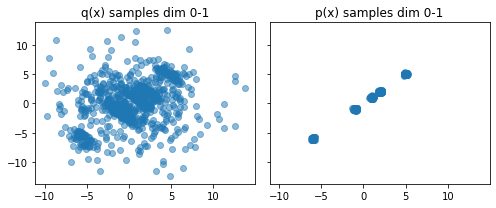

In [23]:
plot_samples(tester, samples_q=samples_NUTS)

# HMC

In [15]:
HMC_time = timer("HMC")
x_HMC = HMC(log_q_x=target.log_prob, n_outer=20, epsilon=torch.tensor([0.1]), L=5, current_q=theta_init
                , grad_log_q_x=None)
HMC_time.stop()


Duration of 0.25885891914367676 for HMC



In [16]:
estimated_expectation = torch.mean(expectation_function(x_HMC))
estimated_expectation

tensor(67.1071, grad_fn=<MeanBackward0>)

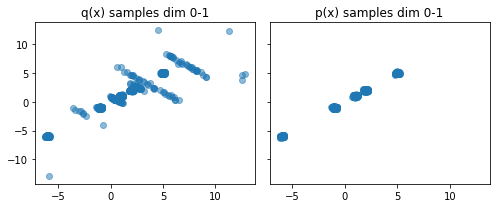

In [17]:
plot_samples(tester, samples_q=x_HMC)

# Metropolis

In [24]:
Metro_time = timer("Metropolis")
metro_class = Metropolis(n_updates=20,
                                      step_size=torch.tensor(1.0), trainable=False)
x_metropolis = metro_class.run(theta_init, log_p_x_func=target.log_prob)
Metro_time.stop()


Duration of 0.10678625106811523 for Metropolis



In [25]:
estimated_expectation = torch.mean(expectation_function(x_metropolis))
estimated_expectation

tensor(63.5694, grad_fn=<MeanBackward0>)

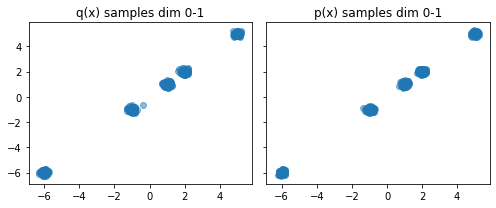

In [26]:
plot_samples(tester, samples_q=x_metropolis)